# Generative AI - GAN
### Content
1. Vanilla GAN
2. ConditionalGAN
3. CycleGAN
4. BigGAN
5. StyleGAN

## Vanilla GAN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import save_image


In [2]:
# Hyperparameters
latent_size = 64
hidden_size = 256
image_size = 784
batch_size = 100
num_epochs = 200
learning_rate = 0.0002

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to denormalize images
def denorm(x):
    out = (x + 0.5) / 0.5
    return out.clamp(0, 1)

In [3]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)
        

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)
        

In [5]:
# Transform and DataLoader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

mnist = datasets.MNIST(root='.', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True)

# Initialize models
D = Discriminator().to(device) 
G = Generator().to(device)

# Binary Cross entropy Loss and optimizer
criterion = nn.BCELoss()
optimizer_g = optim.Adam(G.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(D.parameters(), lr=learning_rate)


In [ ]:
# Training loop
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load real images
        images = images.view(batch_size, -1).to(device)
        
        # Create labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Train Discriminator
        optimizer_d.zero_grad()
        
        output = D(images)
        d_loss_real = criterion(output, real_labels)
        real_score = output

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        output = D(fake_images)
        d_loss_fake = criterion(output, fake_labels)
        fake_score = output

        d_loss = d_loss_real + d_loss_fake
        
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        output = D(fake_images)

        g_loss = criterion(output, real_labels)

        g_loss.backward()
        optimizer_g.step()
        

        if (i+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], '
                  f'D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}, '
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')

    # Save real images
    if (epoch+1) == 1:
        images = images.view(images.size(0), 1, 28, 28)
        save_image(denorm(images), './GAN/real_images.png')

    # Save sampled images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), f'./GAN/fake_images-{epoch+1}.png')

In [ ]:
# Save the model checkpoints
torch.save(D.state_dict(), './GAN/D.pth')
torch.save(G.state_dict(), './GAN/G.pth')

### Load saved model and create images

In [8]:
# Hyperparameters
latent_size = 64
num_images = 25  # Number of images to generate
model_path = './GAN_Models/G.pth'  # Path to the trained Generator model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Load the trained Generator model
G = Generator().to(device)
G.load_state_dict(torch.load(model_path))
G.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [10]:
z = torch.randn(batch_size, latent_size).to(device)
# Generate images
with torch.no_grad():
    fake_images = G(z)

In [11]:
# Save generated images
fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
save_image(denorm(fake_images), 'generated_images.png', nrow=5)  # Save images in a grid format

## Conditional GAN

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [13]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
lr = 0.0002
num_epochs = 50
z_dim = 100
num_classes = 10
img_size = 28
img_channels = 1

In [14]:
# Image processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# FashionMNIST dataset
train_dataset = datasets.FashionMNIST(root='data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [25]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_channels, img_size):
        super(Generator, self).__init__()
        # Embed the Class Labels to a vector
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        # set initial Size of the image before the upsampling begins.
        self.init_size = img_size // 4

        # Create a Linear layer that maps the concatenated noise and label embeddings to a higher-dimensional space.
        self.l1 = nn.Sequential(nn.Linear(z_dim + num_classes, 128 * self.init_size ** 2))
        
        # Convolutional Block to upscale the image 
        # B.Norm -> UpSample -> conv -> B.Norm -> L.ReLU -> UpSample -> conv -> B.Norm -> L.ReLU -> conv -> tanh
        self.conv_block = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate the label embeddings with the noise vector.
        le = self.label_embedding(labels)
        gen_input = torch.cat((le, noise), -1)
        # Pass the combined vector through the linear layer 
        l1 = self.l1(gen_input)
        # Reshape it into an image-like tensor.
        l1 = l1.view(l1.shape[0], 128, self.init_size, self.init_size)
        
        # Apply the convolutional blocks to generate the final image.
        out = self.conv_block(l1)

        return out
        

class Discriminator(nn.Module):
    def __init__(self, num_classes, img_channels, img_size):
        super(Discriminator, self).__init__()
        
        # Embed the Class Labels to a vector
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        
        # Create helper function to create blocks of convolutional layers
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        # Create convolutional blocks that reduce the spatial dimensions of the input image.
        self.model = nn.Sequential(
            *discriminator_block(img_channels+num_classes, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # Create linear layer that outputs a single value indicating the "realness" of the input image.
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(512 * ds_size ** 2, 1), nn.Sigmoid())
        

    def forward(self, img, labels):
        # Concatenates the label embeddings with the image tensor. bs x c x h x w
        d_in = torch.cat((img, self.label_embedding(labels).view(labels.size(0), num_classes, 1, 1).expand(labels.size(0), num_classes, img.size(2), img.size(3))), 1)
        
        # Passes the combined tensor through the convolutional model.
        out = self.model(d_in)

        # Flattens the output
        out = out.view(out.shape[0], -1)
        
        # Passes it through the adv_layer to get the final validity score.
        realness = self.adv_layer(out)
        return realness
        


In [26]:
# Initialize models
generator = Generator(z_dim, num_classes, img_channels, img_size).to(device)
discriminator = Discriminator(num_classes, img_channels, img_size).to(device)

# Optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function 
adv_loss = nn.BCELoss()

In [ ]:
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size = imgs.size(0)
        
        # Adversarial ground truths
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)
        
        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_d.zero_grad()
        
        # Loss for real images
        real_pred = discriminator(real_imgs, labels)
        d_real_loss = adv_loss(real_pred, valid)
        
        # Generate a batch of fake images
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_img = generator(z, gen_labels)       
        
        # Loss for fake images
        fake_pred = discriminator(gen_img.detach(), gen_labels)
        d_fake_loss = adv_loss(fake_pred, fake)
        
        
        # Total discriminator loss
        d_loss = d_real_loss + d_fake_loss
        

        # Update Discriminator
        d_loss.backward()
        optimizer_d.step()
        

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_g.zero_grad()
        
        # Sample noise and labels as generator input
        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        
        # Generate a batch of images
        gen_img = generator(z, gen_labels)  
        
        # Loss measures generator's ability to fool the discriminator
        realness = discriminator(gen_img, gen_labels)
        g_loss = adv_loss(realness, valid)

        g_loss.backward()
        optimizer_g.step()
        
        
        if i % 400 == 0:
            print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}]\t [D loss: {d_loss.item()}]\t [G loss: {g_loss.item()}]")

    # Save some generated images for inspection
    if epoch % 2 == 0:
        z = torch.randn(64, z_dim).to(device)
        labels = torch.tensor([i for i in range(10) for _ in range(6)] + [0, 1, 2, 3]).to(device)
        gen_imgs = generator(z, labels).cpu().detach()
        fig, axs = plt.subplots(8, 8, figsize=(8, 8))
        for ax, img in zip(axs.flatten(), gen_imgs):
            ax.imshow(img.view(img_size, img_size), cmap='gray')
            ax.axis('off')
        plt.savefig(f'./GAN/cGAN_fakeimages_{epoch}.png')

In [ ]:
# Save the generator model
torch.save(generator.state_dict(), './GAN/cGAN_G.pth')

### Use saved model to generate images

In [29]:
# Hyperparameters
z_dim = 100
num_classes = 10
img_size = 28
img_channels = 1

In [34]:
class Generator_Saved(nn.Module):
    def __init__(self, z_dim, num_classes, img_channels, img_size):
        super(Generator_Saved, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(z_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, img_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_embedding(labels), noise), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [35]:
# Load the generator model
generator = Generator_Saved(z_dim, num_classes, img_channels, img_size).to(device)
generator.load_state_dict(torch.load('./GAN_Models/cGAN_G.pth'))
generator.eval()

Generator_Saved(
  (label_embedding): Embedding(10, 10)
  (l1): Sequential(
    (0): Linear(in_features=110, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

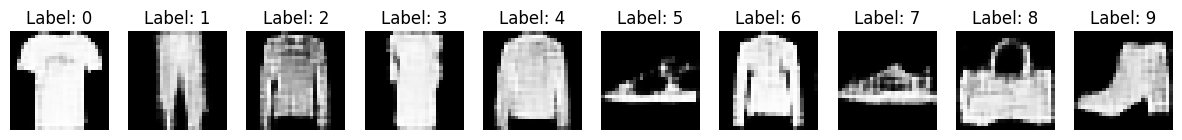

In [36]:
def generate_images(generator, labels):
    z = torch.randn(labels.size(0), z_dim).to(device)
    gen_labels = labels.to(device)
    gen_imgs = generator(z, gen_labels)
    return gen_imgs

# Example: Generate images for given labels
labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).to(device)  # Generating one image per class
gen_imgs = generate_images(generator, labels)

# Plot generated images
fig, axs = plt.subplots(1, 10, figsize=(15, 15))
for ax, img, label in zip(axs, gen_imgs, labels):
    ax.imshow(img.view(img_size, img_size).cpu().detach(), cmap='gray')
    ax.set_title(f"Label: {label.item()}")
    ax.axis('off')
plt.show()

## CycleGAN

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

In [38]:
# Define the generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Define the layers of the generator
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Define the layers of the discriminator
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )

    def forward(self, input):
        return self.main(input)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the networks
G_A2B = Generator().to(device)
G_B2A = Generator().to(device)

D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Loss functions, GAN loss -> MSE, Cycle Loss -> L1
criterian_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()


# Optimizers
optimizer_G_A2B = optim.Adam(G_A2B.parameters(), lr=0.0002)
optimizer_G_B2A = optim.Adam(G_B2A.parameters(), lr=0.0002)
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.0002)
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.0002)


In [41]:
# Data transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load datasets
dataset_A = datasets.ImageFolder(root='/home/ubuntu/data/projects/csc6203/data/summer2winter_yosemite/train/s', transform=transform)
dataset_B = datasets.ImageFolder(root='/home/ubuntu/data/projects/csc6203/data/summer2winter_yosemite/train/w', transform=transform)

loader_A = DataLoader(dataset_A, batch_size=1, shuffle=True)
loader_B = DataLoader(dataset_B, batch_size=1, shuffle=True)

# Function to denormalize and plot images
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # unnormalize
    return tensor

def plot_images(real_A, fake_B, recov_A, real_B, fake_A, recov_B, epoch):
    real_A = denormalize(real_A).cpu().detach().numpy().transpose(1, 2, 0)
    fake_B = denormalize(fake_B).cpu().detach().numpy().transpose(1, 2, 0)
    recov_A = denormalize(recov_A).cpu().detach().numpy().transpose(1, 2, 0)
    real_B = denormalize(real_B).cpu().detach().numpy().transpose(1, 2, 0)
    fake_A = denormalize(fake_A).cpu().detach().numpy().transpose(1, 2, 0)
    recov_B = denormalize(recov_B).cpu().detach().numpy().transpose(1, 2, 0)
    
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes[0, 0].imshow(real_A)
    axes[0, 0].set_title('Real A (Summer)')
    axes[0, 1].imshow(fake_B)
    axes[0, 1].set_title('Fake B (Winter)')
    axes[0, 2].imshow(recov_A)
    axes[0, 2].set_title('Reconstructed A')
    axes[1, 0].imshow(real_B)
    axes[1, 0].set_title('Real B (Winter)')
    axes[1, 1].imshow(fake_A)
    axes[1, 1].set_title('Fake A (Summer)')
    axes[1, 2].imshow(recov_B)
    axes[1, 2].set_title('Reconstructed B')
    for ax in axes.flat:
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f'output/epoch_{epoch}.png')
    plt.show()

# Training loop
num_epochs = 100
os.makedirs('output', exist_ok=True)

Epoch [1/100] Batch 0: Loss_D_A: 1.022084355354309, Loss_D_B: 2.0035526752471924, Loss_G: 10.919329643249512
Epoch [1/100] Batch 500: Loss_D_A: 0.2735814154148102, Loss_D_B: 0.0016605108976364136, Loss_G: 6.337679386138916


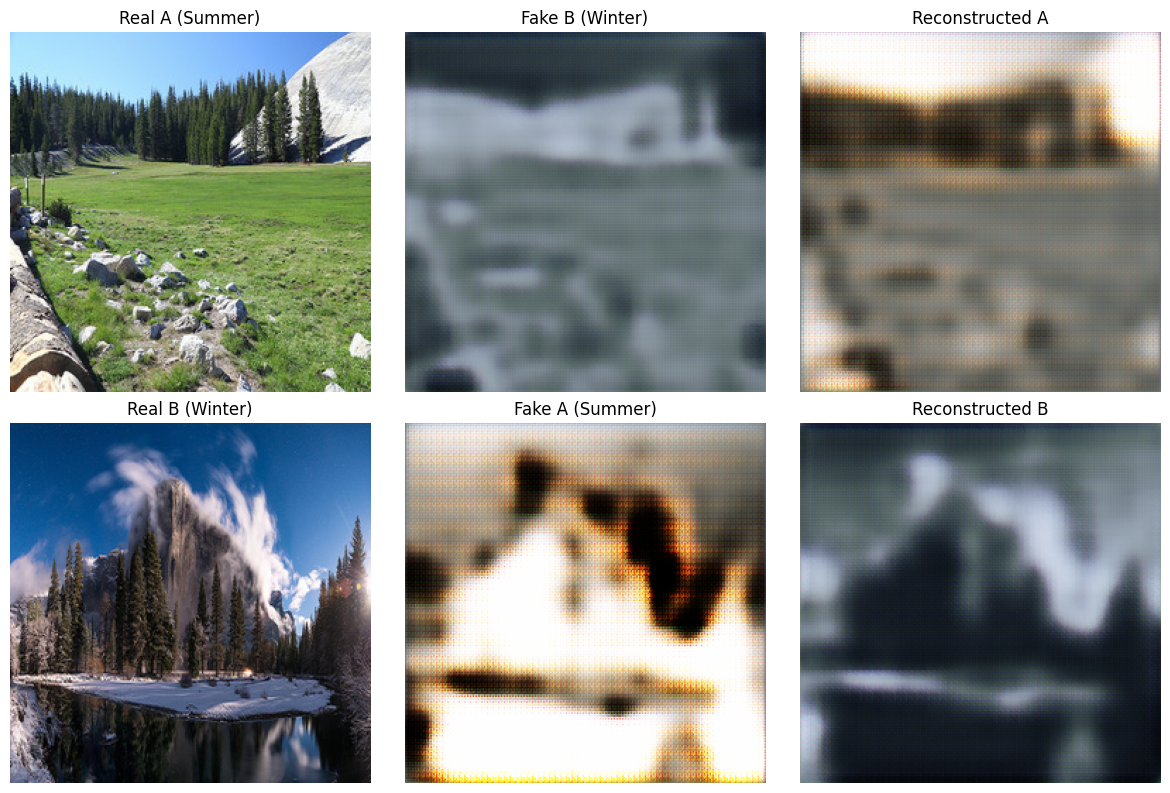

Epoch [2/100] Batch 0: Loss_D_A: 0.3668033182621002, Loss_D_B: 0.0009163201320916414, Loss_G: 4.103992462158203
Epoch [2/100] Batch 500: Loss_D_A: 0.08436216413974762, Loss_D_B: 0.0009976018918678164, Loss_G: 4.958779335021973


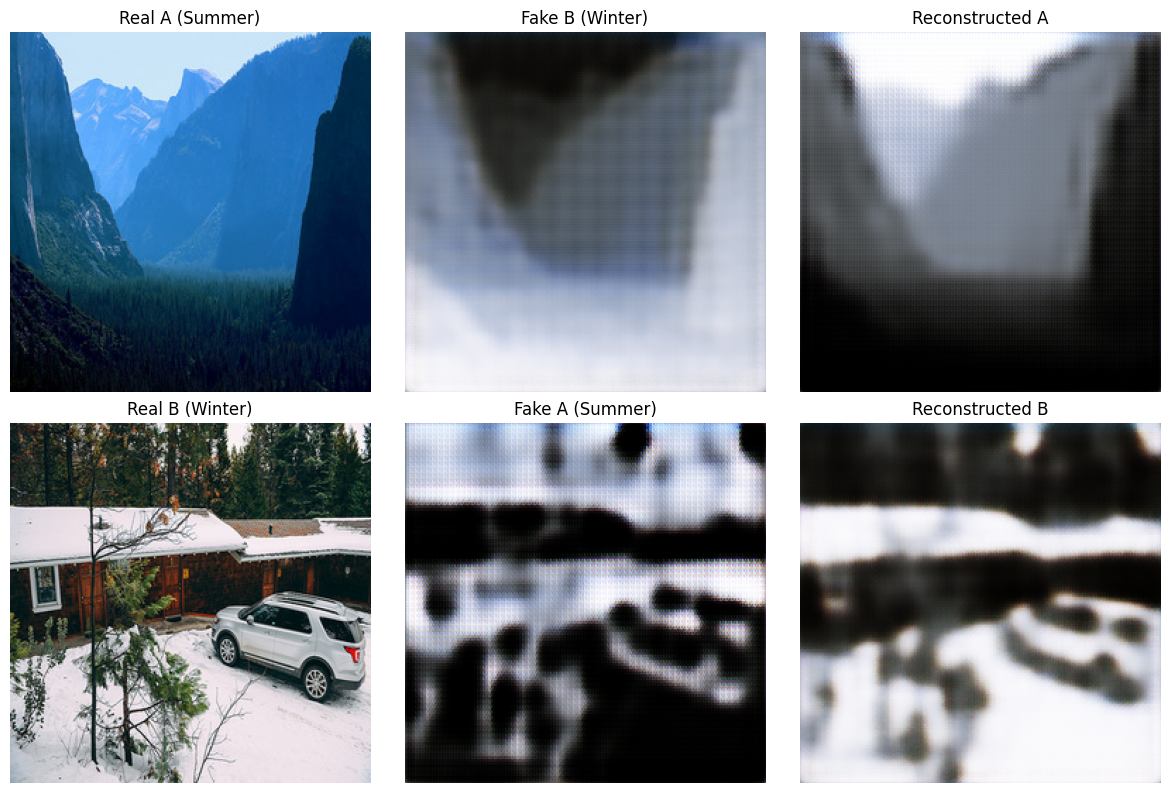

Epoch [3/100] Batch 0: Loss_D_A: 0.05349902808666229, Loss_D_B: 0.0007260955171659589, Loss_G: 6.778103828430176
Epoch [3/100] Batch 500: Loss_D_A: 0.15044118463993073, Loss_D_B: 0.0003467946080490947, Loss_G: 5.232241630554199


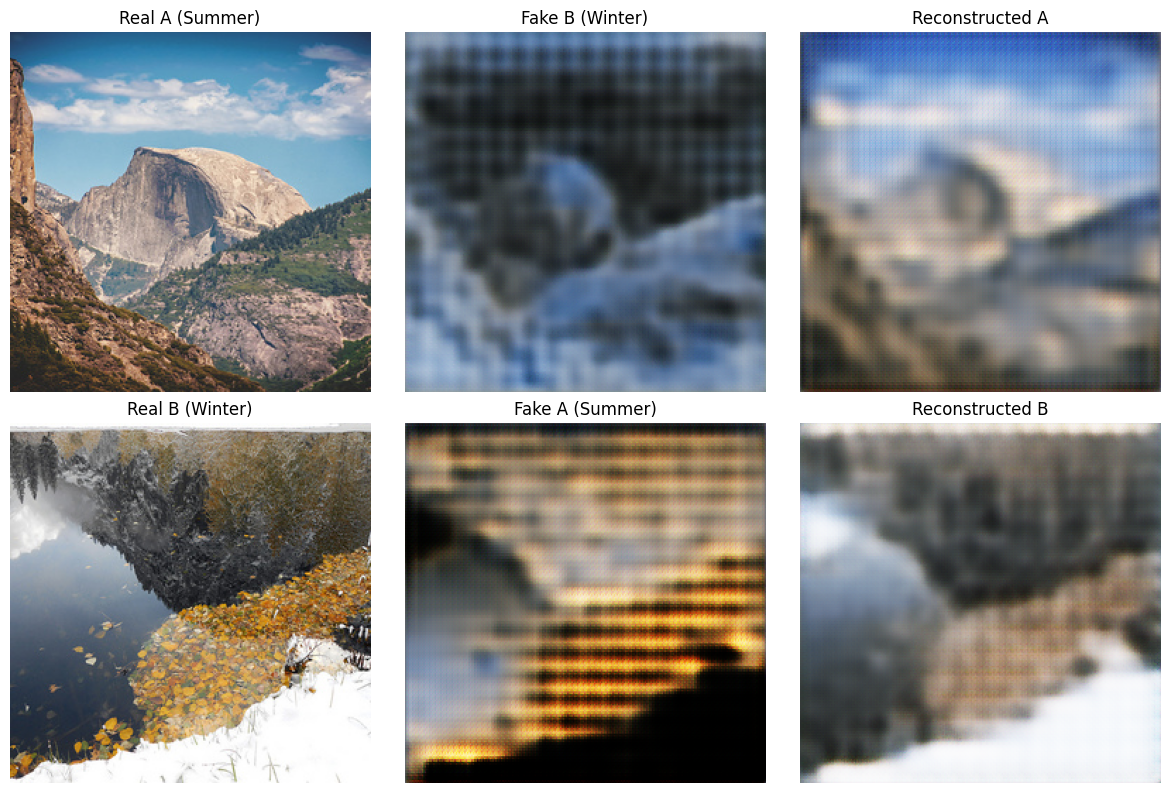

Epoch [4/100] Batch 0: Loss_D_A: 0.2059832513332367, Loss_D_B: 0.0005378285422921181, Loss_G: 3.869554042816162


KeyboardInterrupt: 

In [44]:
for epoch in range(num_epochs):
    for i, (data_A, data_B) in enumerate(zip(loader_A, loader_B)):
        # Get two real images from A and B
        real_A = data_A[0].to(device)
        real_B = data_B[0].to(device) 
  
        # Train Discriminators
        optimizer_D_A.zero_grad()
        optimizer_D_B.zero_grad()

        # Get loss of D_a for real
        loss_D_A_real = criterian_GAN(D_A(real_A), torch.ones_like(D_A(real_A)))
           
        # Create a fake image A from real B
        fake_A = G_B2A(real_B)
        
        # Get loss of D_a for fake
        loss_D_A_fake = criterian_GAN(D_A(fake_A), torch.zeros_like(D_A(fake_A)))

        # Get loss of D_a
        loss_D_A = loss_D_A_real + loss_D_A_fake

        
        # Get loss of D_b for real
        loss_D_B_real = criterian_GAN(D_B(real_B), torch.ones_like(D_B(real_B)))
           
        # Create a fake image B from real A
        fake_B = G_A2B(real_A)
        
        # Get loss of D_b for fake
        loss_D_B_fake = criterian_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        
        # Get loss of D_b
        loss_D_B = loss_D_B_real + loss_D_B_fake

        # Update the Discriminators 
        loss_D_A.backward()
        loss_D_B.backward()

        optimizer_D_A.step()
        optimizer_D_B.step()
        

        # Train Generators
        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()

        # Create two fake images from A and B
        fake_A = G_B2A(real_B)
        fake_B = G_A2B(real_A)
        
        # GAN loss
        loss_G_A2B = criterian_GAN(D_B(fake_B), torch.ones_like(D_B(fake_B)))
        loss_G_B2A = criterian_GAN(D_A(fake_A), torch.ones_like(D_A(fake_A)))


        # Cycle loss
        recov_A = G_B2A(fake_B)
        recov_B = G_A2B(fake_A)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        # Total loss
        loss_G = loss_G_A2B + loss_G_B2A + 10 * loss_cycle_A + 10 * loss_cycle_B
        loss_G.backward()

        # Update Generators
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()
        

        if i % 500 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch {i}: Loss_D_A: {loss_D_A.item()}, Loss_D_B: {loss_D_B.item()}, Loss_G: {loss_G.item()}")

    # Plot images after each epoch
    plot_images(real_A[0], fake_B[0], recov_A[0], real_B[0], fake_A[0], recov_B[0], epoch)

print("Training Complete!")

In [ ]:
# Save the generator model
torch.save(G_A2B.state_dict(), './GAN/cycleGAN_G_A2B.pth')
torch.save(G_B2A.state_dict(), './GAN/cycleGAN_G_B2A.pth')


### Use Saved model

In [45]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [47]:
# Load the trained generator model
generator = Generator().to(device)
generator.load_state_dict(torch.load('./GAN_Models/cycleGAN_G_A2B.pth'))
generator.eval()

Generator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (15): Tanh()
  )
)

In [50]:
# Define the transformation for the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to denormalize the output image
def denormalize(tensor):
    tensor = tensor * 0.5 + 0.5  # unnormalize
    return tensor

# Load and transform the input image
input_image = Image.open('/home/ubuntu/data/projects/csc6203/data/summer2winter_yosemite/test/summer/2010-09-07 12:23:20.jpg')
input_image_transformed = transform(input_image).unsqueeze(0).to(device)

In [51]:
# Generate the winter image
with torch.no_grad():
    output_image = generator(input_image_transformed).squeeze(0)

# Convert the output tensor to a PIL image
output_image = denormalize(output_image).cpu().numpy().transpose(1, 2, 0)
output_image = (output_image * 255).astype('uint8')
output_image = Image.fromarray(output_image)


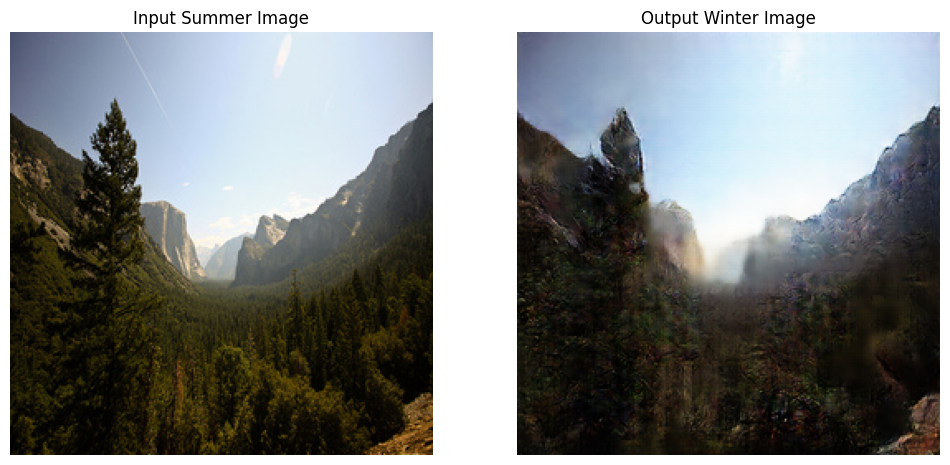

In [52]:
# Display the input and output images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Input Summer Image")
plt.imshow(input_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Output Winter Image")
plt.imshow(output_image)
plt.axis('off')

plt.show()

## BigGAN

In [53]:
import torch
from torchvision.utils import save_image
from pytorch_pretrained_biggan import BigGAN, one_hot_from_int, one_hot_from_names, truncated_noise_sample
from PIL import Image


In [55]:
# Load the pretrained BigGAN model
model = BigGAN.from_pretrained("biggan-deep-256").to(device)

In [56]:
# Set the model to evaluation mode
model.eval()

BigGAN(
  (embeddings): Linear(in_features=1000, out_features=128, bias=False)
  (generator): Generator(
    (gen_z): Linear(in_features=256, out_features=32768, bias=True)
    (layers): ModuleList(
      (0-2): 3 x GenBlock(
        (bn_0): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=2048, bias=False)
          (offset): Linear(in_features=256, out_features=2048, bias=False)
        )
        (conv_0): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1))
        (bn_1): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn_2): BigGANBatchNorm(
          (scale): Linear(in_features=256, out_features=512, bias=False)
          (offset): Linear(in_features=256, out_features=512, bias=False)
        )
        (conv_2): Conv2d(512, 512, kernel_siz

In [57]:
# Function to generate images
def generate_images(model, class_id=None, class_name=None, num_images=1, truncation=0.4):
    # Generate latent vectors and class vectors
    noise_vector = truncated_noise_sample(truncation=truncation, batch_size=num_images)
    noise_vector = torch.from_numpy(noise_vector).to(device)
    
    if class_id is not None:
        class_vector = one_hot_from_int([class_idx] * num_images, batch_size=num_images)

    if class_name is not None:
        class_vector = one_hot_from_names([class_name], batch_size=num_images)
        
    class_vector = torch.from_numpy(class_vector).to(device)
    
    # Generate images
    with torch.no_grad():
        images = model(noise_vector, class_vector, truncation)
    
    return images

In [58]:
# Generate images of a specific class (e.g., class 207 is 'Labrador retriever')
class_idx = 207
num_images = 5
images = generate_images(model=model, class_id=class_idx, num_images=num_images)

In [60]:
images = generate_images(model=model, class_name='coffee', num_images=num_images)

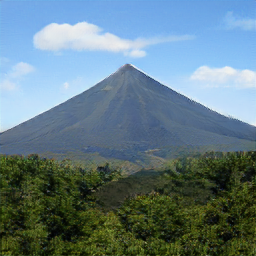

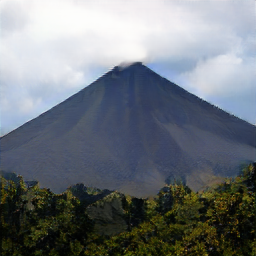

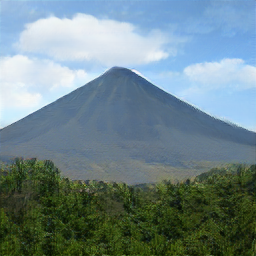

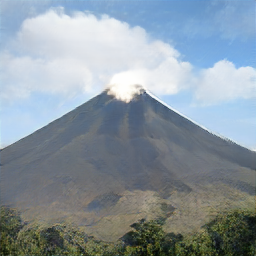

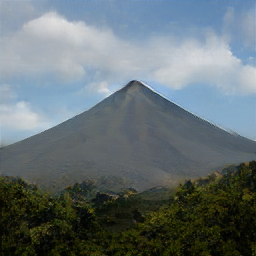

In [61]:
# Save the generated images
for i, img in enumerate(images):
    img = img.cpu().numpy().transpose(1, 2, 0)  
    # Convert to HWC format
    img_pil = Image.fromarray(((img + 1) * 127.5).astype('uint8'))
    img_pil.save(f'generated_image_{i}.png')

# Optionally display the generated images using PIL
for i in range(num_images):
    img_pil = Image.open(f'generated_image_{i}.png')
    img_pil.show()